In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from scipy.stats import kstest
from tqdm import tqdm

In [8]:
ecommerce_data = pd.read_csv("../data/e-commerce.csv")
control = ecommerce_data[(ecommerce_data.group == 'control') & (ecommerce_data.landing_page == 'old_page')]
control

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
4,864975,52:26.2,control,old_page,1
5,936923,20:49.1,control,old_page,0
7,719014,48:29.5,control,old_page,0
...,...,...,...,...,...
294471,718310,44:20.4,control,old_page,0
294473,751197,28:38.6,control,old_page,0
294474,945152,51:57.1,control,old_page,0
294475,734608,45:03.4,control,old_page,0


100%|██████████| 2000/2000 [06:45<00:00,  4.93it/s]


Text(0.5, 0, 'P-value')

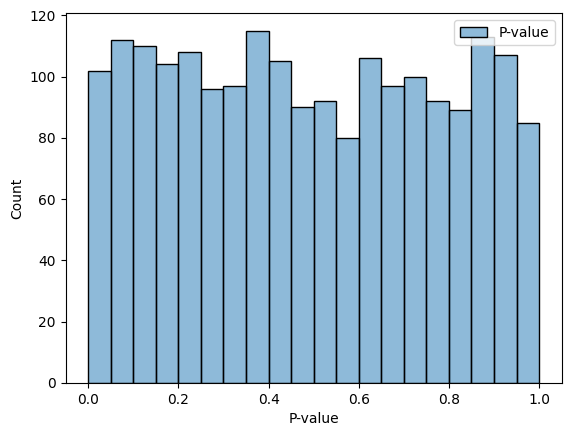

In [9]:
p_values = []

for a in tqdm(range(2000)):
    a1 = control.sample(frac = 0.55)
    a2 = control.drop(a1.index)
    test = ttest_ind(a1['converted'], a2['converted'], equal_var=False)
    p_values.append(test.pvalue)

sns.histplot(data=pd.DataFrame(p_values, columns=['P-value']), bins=20)
plt.xlabel("P-value")

In [10]:
kstest(p_values, "uniform")

KstestResult(statistic=0.027908077306496526, pvalue=0.0870580682611416, statistic_location=0.44659192269350345, statistic_sign=1)

Распределение неравномерное и мы можем наблюдать выбросы. Для борьбы с этим используется винсоризация — ограничение экстремальных значений некоторым максимумом. 